In [1]:
import datetime
import random

import pandas as pd
import numpy as np
import pandas_datareader.data as web

import mlflow
from mlflow.models.signature import infer_signature

from sklearn import datasets, svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt

## Retrieve dataset

In [2]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 12, 31)

In [3]:
btc_df = web.DataReader("BTC-USD", "yahoo", start, end)
btc_df['delta_pct'] = (btc_df['Close'] - btc_df['Open']) / btc_df['Open']

# target variable
btc_df['going_up'] = btc_df['delta_pct'].apply(lambda d: 1 if d > 0.00001 else 0).to_numpy()

In [4]:
btc_df.head()

,High,Low,Open,Close,Volume,Adj Close,delta_pct,going_up
Date,,,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,21056800,457.334015,-0.018310,0
2014-09-18,456.859985,413.104004,456.859985,424.440002,34483200,424.440002,-0.070963,0
2014-09-19,427.834991,384.532013,424.102997,394.795990,37919700,394.795990,-0.069104,0
2014-09-20,423.295990,389.882996,394.673004,408.903992,36863600,408.903992,0.036058,1
2014-09-21,412.425995,393.181000,408.084991,398.821014,26580100,398.821014,-0.022701,0


In [5]:
btc_df.tail()

,High,Low,Open,Close,Volume,Adj Close,delta_pct,going_up
Date,,,,,,,,
2020-12-28,27389.111328,26207.640625,26280.822266,27084.808594,49056742893,27084.808594,0.030592,1
2020-12-29,27370.720703,25987.298828,27081.810547,27362.437500,45265946774,27362.437500,0.010362,1
2020-12-30,28937.740234,27360.089844,27360.089844,28840.953125,51287442704,28840.953125,0.054125,1
2020-12-31,29244.876953,28201.992188,28841.574219,29001.720703,46754964848,29001.720703,0.005553,1
2021-01-01,29600.626953,28803.585938,28994.009766,29374.152344,40730301359,29374.152344,0.013111,1


In [6]:
btc_df.shape

(2299, 8)

<AxesSubplot: xlabel='Date'>

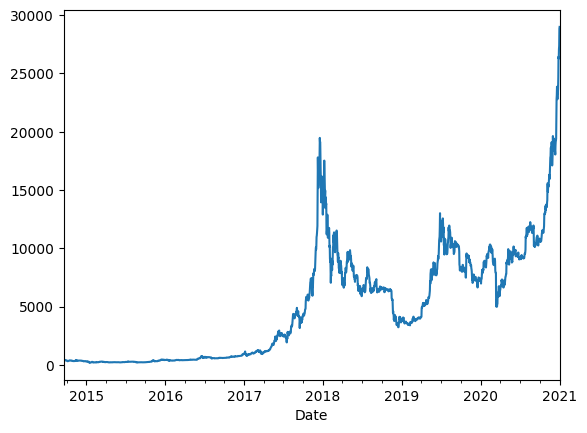

In [7]:
btc_df["Open"].plot()

In [8]:
def rolling_window(a, window):
    """
        Takes np.array 'a' and size 'window' as parameters
        Outputs an np.array with all the ordered sequences of values of 'a' of size 'window'
        e.g. Input: ( np.array([1, 2, 3, 4, 5, 6]), 4 )
             Output: 
                     array([[1, 2, 3, 4],
                           [2, 3, 4, 5],
                           [3, 4, 5, 6]])
    """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


In [9]:
element = btc_df['going_up'].to_numpy()

In [10]:
WINDOW_SIZE=15
training_data = rolling_window(element, WINDOW_SIZE)

In [11]:
training_data.shape

(2285, 15)

In [12]:
X = training_data[:, :-1]
y = training_data[:, -1]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234, stratify=y)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1530, 14) (1530,)
(755, 14) (755,)


## Load the model as `MLflow Pyfunc` for prediction
Full path of the model artifact can be identifide by,  
`MLflow server` $\rightarrow$ `click model run` $\rightarrow$ `Artifacts tab (left)` $\rightarrow$ `Full path`

In [15]:
logged_model = "/data/artifacts/4/97ee9e6938aa4ea7a1ef9fef30f634db/artifacts/model/"

In [16]:
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [17]:
y_pred = loaded_model.predict(X_test)
print(X_test.shape, y_pred.shape)

(755, 14) (755,)


## Managing model signatures and schemas

In [18]:
digits = datasets.load_digits()
print(digits.images.shape)

(1797, 8, 8)


In [19]:
n_samples = len(digits.images)
print(n_samples)

1797


In [20]:
data = digits.images.reshape((n_samples, -1))
print(data.shape)

(1797, 64)


In [21]:
# reference: https://docs.databricks.com/_static/notebooks/mlflow/mlflow-end-to-end-example.html
# keras wrapper: https://gist.github.com/sllynn/36441b1cbb3258f2e619ed0f896b5a97
class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict_proba(model_input)[:,1]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.5, shuffle=False)

In [23]:
mlflow.set_experiment("model_signatures_and_schemas")
mlflow.sklearn.autolog()
with mlflow.start_run(run_name="untuned_support_vector_machine"):
    model = svm.SVC(
        gamma=1e-3,
        probability=True,
    )
    model.fit(X_train, y_train)
    wrappedModel = SklearnModelWrapper(model)
    
    # The MLmodel file contains the signature in JSON of input and output files.
    # For some of the flavors autologged,
    # we will not be able to infer the signature automatically
    # so you can provide the signature inline when logging the model:
    signature = infer_signature(
        X_train,
        wrappedModel.predict(None, X_train)
    )
    mlflow.pyfunc.log_model(
        "support_vector_machine_model",
        python_model=wrappedModel,
        signature=signature,
    )

2022/09/19 16:18:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


```yaml
artifact_path: support_vector_machine_model
flavors:
  python_function:
    cloudpickle_version: 2.2.0
    env: conda.yaml
    loader_module: mlflow.pyfunc.model
    python_model: python_model.pkl
    python_version: 3.10.6
mlflow_version: 1.28.0
model_uuid: 5fdfdd00f72842ec86b98b2ca6ac89f9
run_id: 91c5bce2c09b483992db42838514fd64
signature:
  inputs: '[{"type": "tensor", "tensor-spec": {"dtype": "float64", "shape": [-1, 64]}}]'
  outputs: '[{"type": "tensor", "tensor-spec": {"dtype": "float64", "shape": [-1]}}]'
utc_time_created: '2022-09-19 16:17:54.479476'
```

## Introducing Model Registry
Main idea is to provides a central store model in an organization where all the relevant models are stored and can be accessed by humans and systems.

![model lifecycle](./figures/register_model.png)

## Managing the model development life cycle

![model lifecycle](./figures/development_cycle.png)

![model lifecycle](./figures/stage_transition.png)